In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
from pathlib import Path
import time
from IPython.display import clear_output


In [17]:
BATCH_SIZE = 256
HIDDEN_DIM = 5

In [18]:
transform = transforms.Compose(
        
                [   transforms.Resize(64),
                    transforms.ToTensor()]
                )

dataset = datasets.CIFAR10('../data', train=True, download=True,
                       transform=transform)
# dataset = datasets.MNIST('../data', train=True, download=True,
#                        transform=transform)

# num = (5, 1)
# dataset = [x for x in dataset if x[1] in num]
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE)

100%|██████████| 170498071/170498071 [00:04<00:00, 35216164.45it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


In [19]:
class Generator(nn.Module):
    
    def __init__(self, hidden_dim, out_channels):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dense = nn.Sequential(
        nn.Linear(in_features = hidden_dim, out_features=5*5*256),
        nn.ReLU(),
        nn.BatchNorm1d(5*5*256),
        )
        
        self.conv = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=256, stride = 1, kernel_size = 3, padding = 0), #7x7
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(in_channels=256, out_channels=128, stride = 2, kernel_size = 3, padding = 0), #15x15
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, stride = 2, kernel_size = 3, padding = 0), #31x31
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(in_channels=64, out_channels=out_channels, stride = 2, kernel_size = 4, padding = 0), #64x64
        nn.Sigmoid()
        )
        
        
    def forward(self,x):
        x = self.dense(x)
        x = x.reshape(-1, 256, 5, 5)
        x = self.conv(x)
        
        return x
    
    
class Discriminator(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=128, stride = 2, kernel_size = 3, padding = 1), #15x15
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(0.5),
        nn.Conv2d(in_channels=128, out_channels=128, stride = 2, kernel_size = 3, padding = 0), #15x15
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(0.5),
        nn.Conv2d(in_channels=128, out_channels=128, stride = 2, kernel_size = 3, padding = 0), #7x7
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(0.5),
        nn.Conv2d(in_channels=128, out_channels=64, stride = 1, kernel_size = 3, padding = 0), #5x5
        nn.ReLU(),
        nn.BatchNorm2d(64), 
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.Linear(64 * 5 * 5, 100),
        nn.ReLU(),
        nn.Linear(100, 1),    
        nn.Sigmoid()
        
        )
        
        
    def forward(self,x):
        return self.conv(x)
        

In [93]:
class Generator(nn.Module):
    
    def __init__(self, hidden_dim, out_channels):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dense = nn.Sequential(
        nn.Linear(in_features = hidden_dim, out_features=7*7*256),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*256),
        )
        
        self.conv = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, stride = 1, kernel_size = 5, padding = 0), #11x11
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, stride = 2, kernel_size = 5, padding = 0), #15x15
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(in_channels=64, out_channels=out_channels, stride = 1, kernel_size = 4, padding = 0), #31x31
        nn.Sigmoid()
        )
        
        
    def forward(self,x):
        x = self.dense(x)
        x = x.reshape(-1, 256, 7, 7)
        x = self.conv(x)
        
        return x
    
    
class Discriminator(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=64, stride = 2, kernel_size = 5, padding = 0), #12x12
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(0.3),
        nn.Conv2d(in_channels=64, out_channels=128, stride = 2, kernel_size = 5, padding = 0), #4x4
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout(0.3),
        
        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 1),
        nn.Sigmoid()
        
        )
        
        
    def forward(self,x):
        return self.conv(x)
        

In [20]:
gen = Generator(HIDDEN_DIM, 3)
dis = Discriminator(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen.to(device)
dis.to(device)

loss_fn = nn.BCELoss()

optim_gen = torch.optim.Adam(gen.parameters(), lr = 1e-4)
optim_dis = torch.optim.Adam(dis.parameters(), lr = 1e-4)

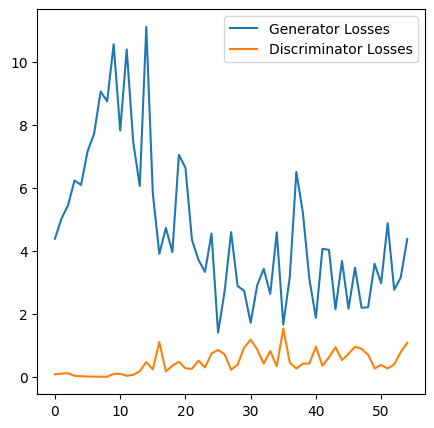

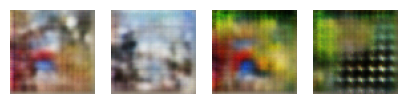

In [ ]:
gen_losses = []
dis_losses = []
plt.figure()
for epoch in tqdm(range(100), position = 0):
    for index, (image, label) in enumerate(train_loader):
        gen.train()
        dis.train()
        sample = torch.randn(BATCH_SIZE, HIDDEN_DIM).to(device)
        fake = gen(sample)
        
        fake_output = dis(fake.detach())
        real_output = dis(image.to(device))
        dis_loss = loss_fn(fake_output, torch.zeros_like(fake_output)) + loss_fn(real_output, torch.ones_like(real_output))
        dis.zero_grad()
        dis_loss.backward()
        optim_dis.step()
        
        fake_output = dis(fake)
        gen_loss = loss_fn(fake_output, torch.ones_like(fake_output))
        gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()
        
    gen_losses.append(gen_loss.item())
    dis_losses.append(dis_loss.item())
        
    clear_output(wait = True)
    plt.figure(figsize=(5, 5))
    plt.plot(gen_losses, label='Generator Losses')
    plt.plot(dis_losses, label='Discriminator Losses')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(5, 5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(fake[i].permute(1,2,0).detach().cpu())
        plt.axis('off')
    plt.show()


In [ ]:
sample = torch.randn(BATCH_SIZE, HIDDEN_DIM).to(device)
gen.eval()
with torch.no_grad():
    gen_res = gen(sample)
plt.figure(figsize=(10,10))
for i in range(8):
    for j in range(1 , 9):
        plt.subplot(8, 8, 8 * i + j)
        plt.imshow(gen_res[8 * i + j - 1].permute(1,2,0).detach().cpu(), cmap = 'gray')
        plt.axis('off')

In [1]:
def transpose_shape(size, kernel, stride, padding):
    return (size - 1) * stride - 2 * padding + kernel
def conv_shape(size, kernel, stride, padding):
    return (size + 2 * padding - kernel) / stride // 1 + 1